# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Maria Luciani

*Semester:* Fall 2024

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

2024-12-12 11:38:20.950780: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

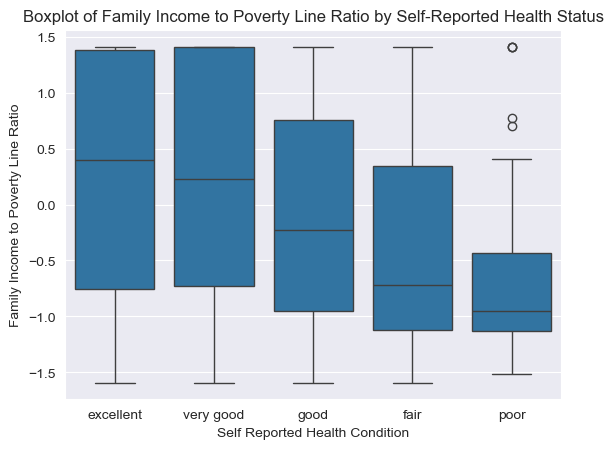

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010 
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

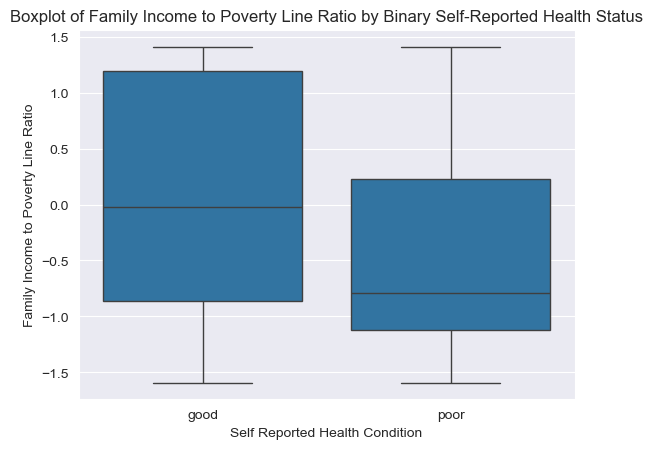

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

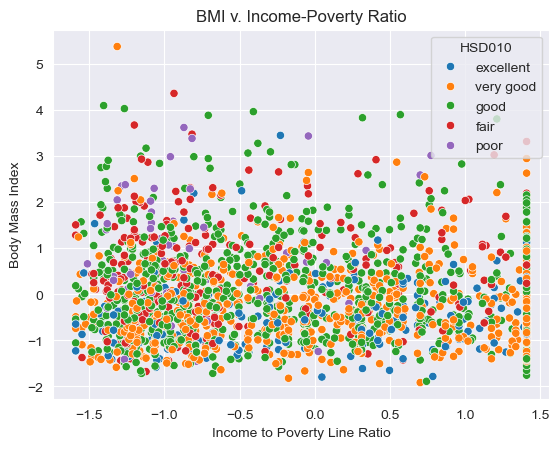

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index") 
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

To choose the number of components that explain the most variability in the feature space with the smallest number of components, I'll use a scree graph to see where the "elbow" is that indicates the new information added is beginning to level out. I'll also consider Eigenvalues (a common cutoff is 1) and & total variance explained (would be nice to get around 80%).

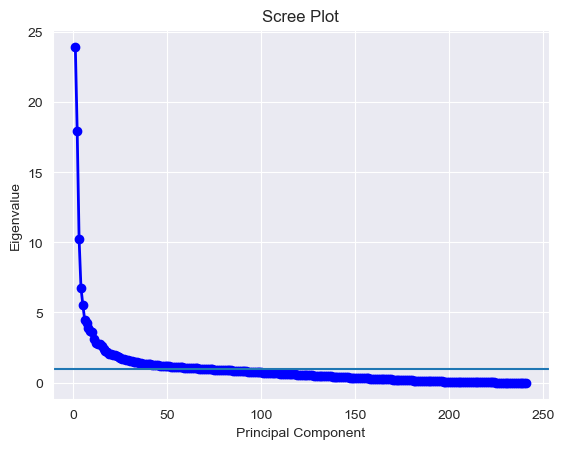

In [7]:
## Your Answer Here

# fit PCA with all components included
pca_all = PCA()
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)

# Create a Scree plot to evaluate the number of components to keep
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1) # adding line to assess where Eigenvalue ~ 1
plt.show()

It looks like the "elbow" is occurring somewhere between 0 and 100 components. I'm going to zoom in there a bit to see if I can tell where exactly that takes place.

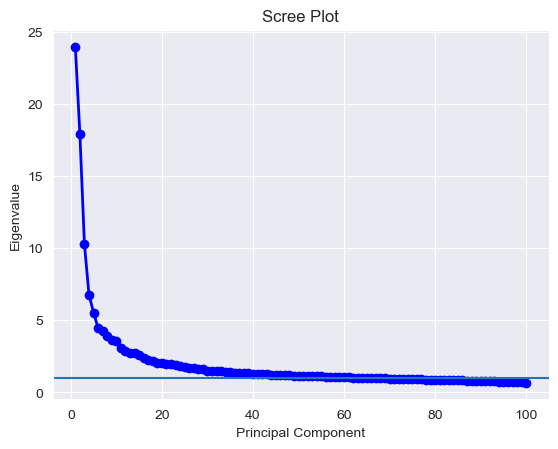

In [8]:
## Your Answer Here

# fit PCA with all components included
pca_all = PCA(n_components = 100)
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)

# Create a Scree plot to evaluate the number of components to keep
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1) # adding line to assess where Eigenvalue ~ 1
plt.show()

Based on the skree plot, it looks like things begin to level out quite a bit after the sixth component, a bit more around 10, then continues for a while, then *really* levels out around 35 or 40. It's kind of hard to interpret. It also looks like the Eigenvalue = 1 cutoff (which is to be fair a bit arbitrary) occurs around 50.

In [9]:
pca_50 = PCA(n_components = 50)
principalComponents_nhanes = pca_50.fit_transform(nhanes_scaled)

sum(pca_50.explained_variance_ratio_)

0.6470837204455746

The total variance explained by the first 50 components is only 65%, which is less than I would like, but the whole point of this thing is to reduce dimensions so I don't really want to let it get too big. If I wasn't looking at variance explained, I might be tempted to limit to 6 prinicipal components. But that would only explain around 29%, which is just too low. I'm going to call it at 50 components.

In [10]:
# Fit PCA with 50 components
pca = PCA(n_components =50)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

### Barplot of Components

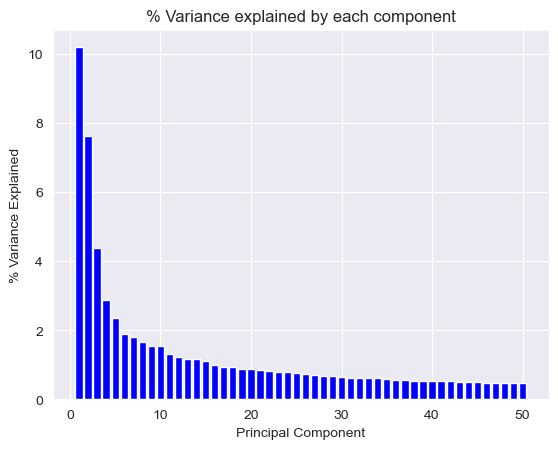

In [11]:
## Your Answer Here

PC_values = np.arange(pca.n_components_) + 1
plt.bar(PC_values, pca.explained_variance_ratio_*100, color='blue', width=0.8)
plt.title('% Variance explained by each component')
plt.xlabel('Principal Component')
plt.ylabel('% Variance Explained')
plt.show()

In [12]:
pca.explained_variance_ratio_

array([0.10201961, 0.07623011, 0.04371192, 0.02882171, 0.02357131,
       0.01901628, 0.01810847, 0.0165558 , 0.01557105, 0.01532161,
       0.01319915, 0.01212691, 0.01157837, 0.01155855, 0.01109489,
       0.01004376, 0.00941733, 0.00931728, 0.00879729, 0.00868392,
       0.00838184, 0.00824045, 0.00794144, 0.00780769, 0.0075193 ,
       0.00720691, 0.00705401, 0.00687219, 0.0067429 , 0.00637392,
       0.00629844, 0.00623253, 0.0061532 , 0.00612077, 0.0057941 ,
       0.00563041, 0.00552984, 0.00544853, 0.00539092, 0.00529383,
       0.00522963, 0.0052139 , 0.00512807, 0.00507209, 0.00504155,
       0.00487001, 0.00479448, 0.00477892, 0.00469312, 0.00463187])

### How many components will you use to fit a supervised learning model?

As I discussed above, I'll use 50 components. This feels like both too many and too few depending on the metric of evaluation, but I'm hoping it will be a fine compromise. We'll see how it goes!

### 2D Scatterplot of the first two components

In [48]:
# convert pca to df

pca_df = pd.DataFrame(data = principalComponents_nhanes)

# Loop over columns to rename them
new_column_names = [f'principal component {i+1}' for i in range(len(pca_df.columns))]
pca_df.columns = new_column_names

pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50
0,9.527808,-0.816219,1.867096,-2.110566,3.929721,-0.186086,3.841668,-2.932114,1.513288,0.695559,...,0.021974,-1.688968,0.253253,-0.725179,0.284712,-0.688218,-0.957904,0.316151,-0.190833,0.547013
1,-5.838334,-3.692596,-3.806042,-1.029230,-0.394447,1.598972,-2.706452,-0.754270,0.382209,-2.386670,...,-1.486630,0.381519,1.463686,-5.417545,-0.551073,1.517697,-0.523824,-1.673902,0.212576,-3.922424
2,-0.719453,-2.573212,-0.908055,-4.755486,1.798438,0.864528,1.024676,0.631144,0.535526,0.442381,...,-0.578334,-0.689138,0.053003,-0.967694,-0.207076,-0.404572,0.001006,0.781596,-0.341233,1.017508
3,3.533628,-2.576972,3.249212,-0.405004,-4.000138,1.444493,1.183428,0.332553,-4.145382,-1.255179,...,0.221039,0.089721,-0.354538,-0.385361,-0.053062,-0.574828,0.292813,-0.491778,0.343587,1.113690
4,-6.872096,-4.194249,-0.886875,-0.849530,0.523358,0.073341,-0.845312,0.986381,0.545756,-0.044363,...,-0.816935,-0.334170,-0.001399,-0.664955,1.565415,-0.690121,0.047136,0.520733,0.637028,-0.431068


In [14]:
# add label back to df for plotting purposes
nhanes_plot = nhanes_scaled.copy()
nhanes_plot['HSD010_binary'] = hsd010_binary

nhanes_plot.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010_binary
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,good
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,good
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,good
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,good
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good


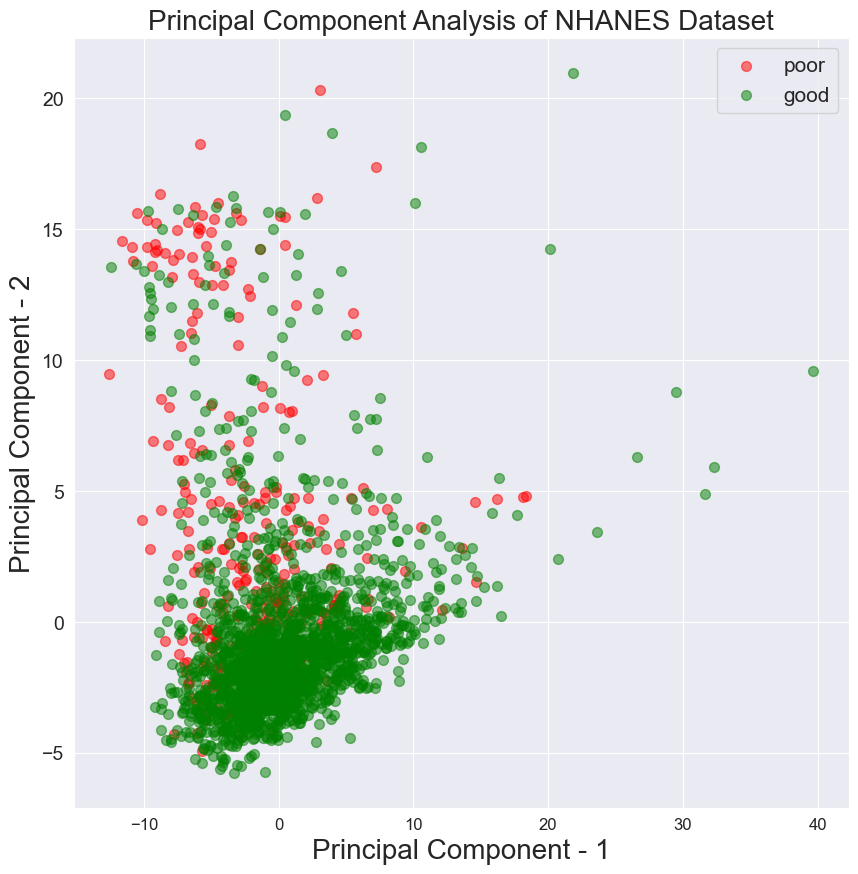

In [15]:
## Your Answer Here

# plot
# ----------

# reset indices so it doesn't give an error
nhanes_plot = nhanes_plot.reset_index(drop=True)
pca_df = pca_df.reset_index(drop=True)

# figure settings
plt.figure(figsize=(10, 10))  # Set the figure size

# Label settings
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset", fontsize=20)

# Define targets and colors for scatterplot
targets = ['poor', 'good']
colors = ['r', 'g']

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Filter the indices based on the target value
    indicesToKeep = nhanes_plot['HSD010_binary'] == target
    # Scatter plot the points corresponding to the current target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1'],
                pca_df.loc[indicesToKeep, 'principal component 2'],
                c=color, s=50, label=target, alpha=0.5)

# Add legend
plt.legend(prop={'size': 15})

# Show the plot
plt.show()

The scatterplot of the first two componenets gives us a little information about how each component predicts health. It seems that most "good" binary health evaluations are clustered lower on PC 1 and lower on PC 2, while most "bad" evaluations are similarly low on PC 1 but higher on PC 2. Because neither of the first two components explained more than about 10% of the total variance in features, it makes sense that there may not be much clearer interpretations than that -- there's a lot more going on in this dataset. The slight separation between red and green makes me optimistic these components may do a fine job of predicting health.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

The clustering algorithm I'll use here is k-means clustering. Unlike PCA which reduces the number of *features*, k-means clustering is an unsupervised method of reducing the number of *cases* by grouping cases that behave similarly within the df. This specific method of clustering works by grouping cases into one of a pre-specified number of clusters optimizing to reduce within-cluster variation. To start, the algorithm randomly assigns cases to a cluster, the center of each cluster is calculated, and the cases are re-assigned to whichever center is nearest. This process is repeated until the clusters are stable.

### Cluster nhanes

I'm going to start with looking at the elbow method for choosing number of k. I'll see if there's a number k where inertia begins to drop off. Interia is the sum of squared distance from each data point to the cluster center, something we'd like to minimize so clusters can be thought of as holding together a bit more.

In [31]:
## Your Answer Here

inertia = []
k_range = range(1, 15) # choosing to look at k between 1 and 15

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nhanes_scaled)
    inertia.append(kmeans.inertia_)

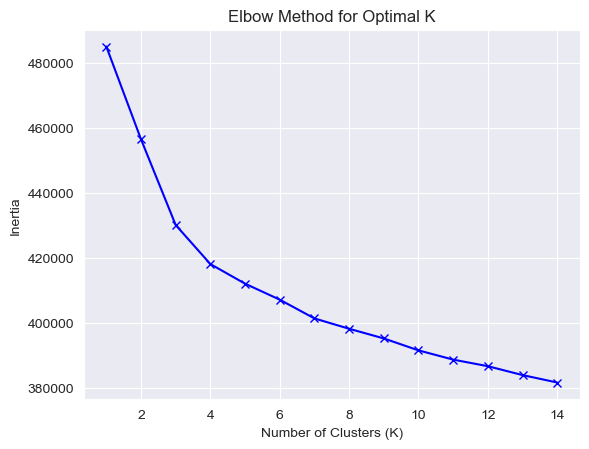

In [30]:
plt.plot(k_range, inertia, 'bx-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

There's really not a clear "elbow" here, which is not super helpful. If I had to estimate one I would say things begin to slow down significantly after 4 clusters. I don't really have the necessary domain knowledge to know what a theoretically-grounded value for k might be, but I can imagine that 4 might be a reasonable number -- maybe it's people who have healthy lifestyles and good health outcomes, healthy lifestyles and poor health outcomes, unhealthy lifestyles and good health outcomes, and unhealthy lifestyles and poor health outcomes? Just a guess, nothing to support that right now. 

Anyways, I will go with 4 clusters based on the elbow method.

In [32]:
# fit k-means with 4 clusters to nhanes data
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(nhanes_scaled)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [40]:
# add cluster label to plot df
nhanes_plot2 = nhanes_plot.copy()
nhanes_plot2['Cluster'] = kmeans.labels_

nhanes_plot2.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010_binary,Cluster
0,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,good,1
1,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,good,2
2,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,good,3
3,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,good,3
4,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,good,2


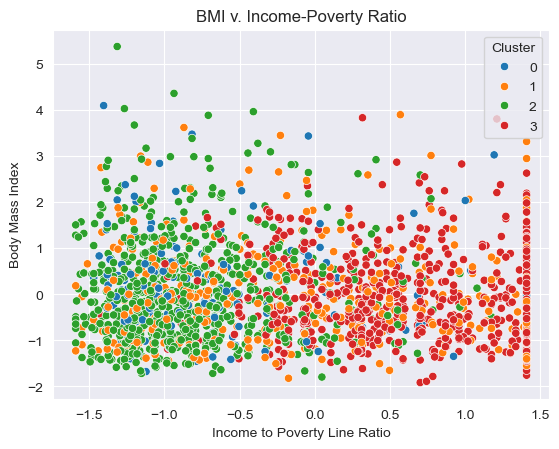

In [43]:
## Your Answer Here

# plot clusters over BMI x Income/Poverty scatterplot
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "Cluster", palette = "tab10", data = nhanes_plot2)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index") 
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Plotting the clusters on the scatterplot of BMI and Income to Pverty Line Ratio reveals some relationship between cluster label and these two features. Clusters 0 and 1 don't seem to be doing much here, but it's clear that cluster 2 is concentrated in the low income-poverty line ratio end and cluster 3 is concentrated on the higher end of this ratio. So, we can imagine that clusters 2 and 3 may contain poorer and richer cases, respectively, while clusters 0 and 1 may be less related to either BMI or income.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [50]:
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 41,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50
0,9.527808,-0.816219,1.867096,-2.110566,3.929721,-0.186086,3.841668,-2.932114,1.513288,0.695559,...,0.021974,-1.688968,0.253253,-0.725179,0.284712,-0.688218,-0.957904,0.316151,-0.190833,0.547013
1,-5.838334,-3.692596,-3.806042,-1.029230,-0.394447,1.598972,-2.706452,-0.754270,0.382209,-2.386670,...,-1.486630,0.381519,1.463686,-5.417545,-0.551073,1.517697,-0.523824,-1.673902,0.212576,-3.922424
2,-0.719453,-2.573212,-0.908055,-4.755486,1.798438,0.864528,1.024676,0.631144,0.535526,0.442381,...,-0.578334,-0.689138,0.053003,-0.967694,-0.207076,-0.404572,0.001006,0.781596,-0.341233,1.017508
3,3.533628,-2.576972,3.249212,-0.405004,-4.000138,1.444493,1.183428,0.332553,-4.145382,-1.255179,...,0.221039,0.089721,-0.354538,-0.385361,-0.053062,-0.574828,0.292813,-0.491778,0.343587,1.113690
4,-6.872096,-4.194249,-0.886875,-0.849530,0.523358,0.073341,-0.845312,0.986381,0.545756,-0.044363,...,-0.816935,-0.334170,-0.001399,-0.664955,1.565415,-0.690121,0.047136,0.520733,0.637028,-0.431068


In [49]:
## Your Answer Here
# fit k-means with 4 clusters to pca results
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

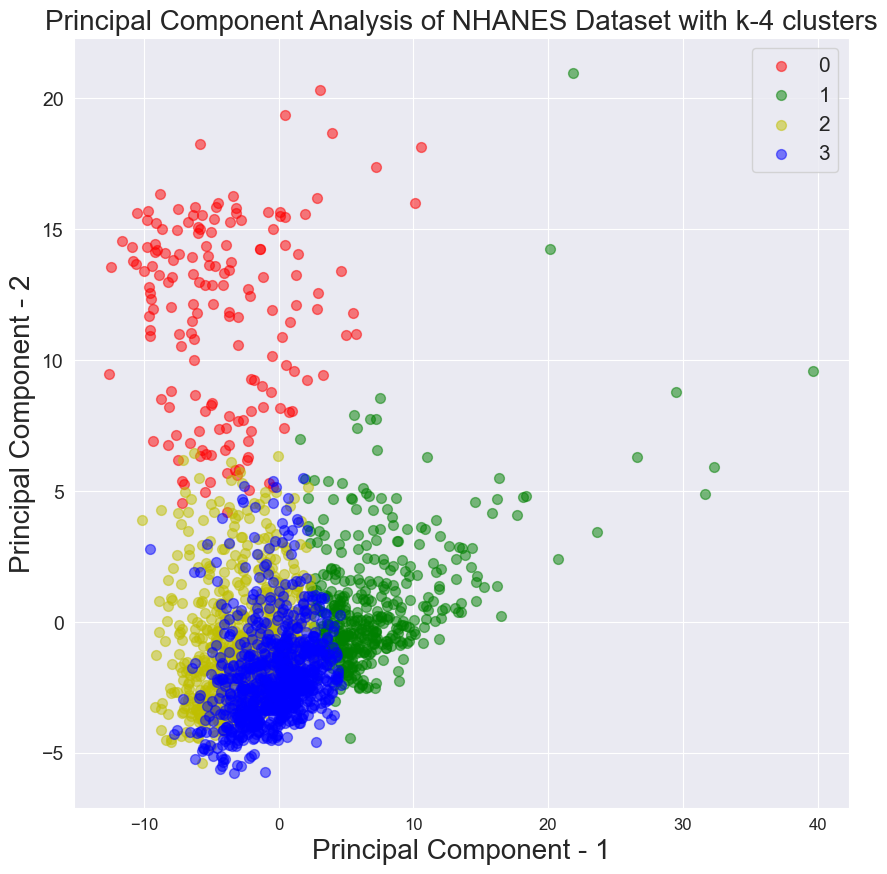

In [52]:
# plot first 2 componenents with clusters

# plot
# ----------

# reset indices so it doesn't give an error
#nhanes_plot2 = nhanes_plot2.reset_index(drop=True)
#pca_df = pca_df.reset_index(drop=True)

# figure settings
plt.figure(figsize=(10, 10))  # Set the figure size

# Label settings
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.ylabel('Principal Component - 2', fontsize=20)
plt.title("Principal Component Analysis of NHANES Dataset with k-4 clusters", fontsize=20)

# Define targets and colors for scatterplot
targets = [0, 1, 2, 3]
colors = ['r', 'g', 'y', 'b']

# Loop over targets and colors to create scatterplot
for target, color in zip(targets, colors):
    # Filter the indices based on the target value
    indicesToKeep = nhanes_plot2['Cluster'] == target
    # Scatter plot the points corresponding to the current target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1'],
                pca_df.loc[indicesToKeep, 'principal component 2'],
                c=color, s=50, label=target, alpha=0.5)

# Add legend
plt.legend(prop={'size': 15})

# Show the plot
plt.show()

Okay, that's pretty cool! When plotting the k=4 clusters over the first two components of our PCA we can see four relatively distinct cluster groupings. Clusters 0 and 3 seem to map onto higher and lower values of PC 2, and clusters 1 and 2 seem to map onto higher and lower values of PC 1. This makes me feel optimistic -- maybe we will be able to make a decent model using our PCA and k-means clustering dimensionality reduction techniques. At the very least I feel like maybe I didn't mess up the coding too much since there is some coherence within clusters!

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [74]:
# first need to recode nhanes to have values 0, 1, 2, 3, 4 so I can correctly say there are 5 classes.
# it's currently 1,2,3,4,5 which would give an error.

hsd010 = hsd010 - 1

In [76]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [77]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5 # number of potential classes of self-reported health
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [82]:
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


In [83]:
len(nhanes_scaled)

2064

In [92]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(241, input_dim= 241, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 - 3s - 430ms/step - accuracy: 0.3689 - loss: 1.4658 - val_accuracy: 0.4302 - val_loss: 1.3326
Epoch 2/10
8/8 - 0s - 29ms/step - accuracy: 0.5045 - loss: 1.2126 - val_accuracy: 0.4457 - val_loss: 1.2733
Epoch 3/10
8/8 - 0s - 25ms/step - accuracy: 0.5394 - loss: 1.1128 - val_accuracy: 0.4477 - val_loss: 1.2451
Epoch 4/10
8/8 - 0s - 25ms/step - accuracy: 0.5814 - loss: 1.0359 - val_accuracy: 0.4554 - val_loss: 1.2281
Epoch 5/10
8/8 - 0s - 26ms/step - accuracy: 0.6163 - loss: 0.9735 - val_accuracy: 0.4535 - val_loss: 1.2234
Epoch 6/10
8/8 - 0s - 44ms/step - accuracy: 0.6402 - loss: 0.9164 - val_accuracy: 0.4574 - val_loss: 1.2153
Epoch 7/10
8/8 - 0s - 29ms/step - accuracy: 0.6809 - loss: 0.8624 - val_accuracy: 0.4612 - val_loss: 1.2113
Epoch 8/10
8/8 - 0s - 31ms/step - accuracy: 0.6996 - loss: 0.8164 - val_accuracy: 0.4651 - val_loss: 1.2153
Epoch 9/10
8/8 - 0s - 35ms/step - accuracy: 0.7306 - loss: 0.7652 - val_accuracy: 0.4612 - val_loss: 1.2205
Epoch 10/10
8/8 - 0s - 37ms

### Neural Network on Principal Components

In [94]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_df # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [95]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5 # number of potential classes of self-reported health
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [96]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(50, input_dim= 50, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 - 4s - 474ms/step - accuracy: 0.2209 - loss: 1.6156 - val_accuracy: 0.3508 - val_loss: 1.5683
Epoch 2/10
8/8 - 0s - 28ms/step - accuracy: 0.3831 - loss: 1.5403 - val_accuracy: 0.4205 - val_loss: 1.5050
Epoch 3/10
8/8 - 0s - 27ms/step - accuracy: 0.4367 - loss: 1.4767 - val_accuracy: 0.4264 - val_loss: 1.4527
Epoch 4/10
8/8 - 0s - 28ms/step - accuracy: 0.4587 - loss: 1.4234 - val_accuracy: 0.4360 - val_loss: 1.4084
Epoch 5/10
8/8 - 0s - 26ms/step - accuracy: 0.4658 - loss: 1.3750 - val_accuracy: 0.4399 - val_loss: 1.3716
Epoch 6/10
8/8 - 0s - 33ms/step - accuracy: 0.4787 - loss: 1.3332 - val_accuracy: 0.4438 - val_loss: 1.3410
Epoch 7/10
8/8 - 0s - 24ms/step - accuracy: 0.4910 - loss: 1.2965 - val_accuracy: 0.4574 - val_loss: 1.3156
Epoch 8/10
8/8 - 0s - 23ms/step - accuracy: 0.4955 - loss: 1.2638 - val_accuracy: 0.4651 - val_loss: 1.2955
Epoch 9/10
8/8 - 0s - 26ms/step - accuracy: 0.4961 - loss: 1.2358 - val_accuracy: 0.4709 - val_loss: 1.2794
Epoch 10/10
8/8 - 0s - 25ms

### Neural Network on Principal Components + Cluster Membership

In [97]:
# make feature df

pca_k = pca_df.copy()
pca_k['Cluster'] = kmeans.labels_

pca_k.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 42,principal component 43,principal component 44,principal component 45,principal component 46,principal component 47,principal component 48,principal component 49,principal component 50,Cluster
0,9.527808,-0.816219,1.867096,-2.110566,3.929721,-0.186086,3.841668,-2.932114,1.513288,0.695559,...,-1.688968,0.253253,-0.725179,0.284712,-0.688218,-0.957904,0.316151,-0.190833,0.547013,0
1,-5.838334,-3.692596,-3.806042,-1.029230,-0.394447,1.598972,-2.706452,-0.754270,0.382209,-2.386670,...,0.381519,1.463686,-5.417545,-0.551073,1.517697,-0.523824,-1.673902,0.212576,-3.922424,2
2,-0.719453,-2.573212,-0.908055,-4.755486,1.798438,0.864528,1.024676,0.631144,0.535526,0.442381,...,-0.689138,0.053003,-0.967694,-0.207076,-0.404572,0.001006,0.781596,-0.341233,1.017508,1
3,3.533628,-2.576972,3.249212,-0.405004,-4.000138,1.444493,1.183428,0.332553,-4.145382,-1.255179,...,0.089721,-0.354538,-0.385361,-0.053062,-0.574828,0.292813,-0.491778,0.343587,1.113690,1
4,-6.872096,-4.194249,-0.886875,-0.849530,0.523358,0.073341,-0.845312,0.986381,0.545756,-0.044363,...,-0.334170,-0.001399,-0.664955,1.565415,-0.690121,0.047136,0.520733,0.637028,-0.431068,2


In [98]:
# partition data
# -----------
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
X = pca_k # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [99]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 5 # number of potential classes of self-reported health
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [104]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(51, input_dim= 51, kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here

model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

/opt/anaconda3/envs/CSS/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 - 10s - 1s/step - accuracy: 0.3295 - loss: 1.5751 - val_accuracy: 0.3779 - val_loss: 1.5354
Epoch 2/10
8/8 - 1s - 69ms/step - accuracy: 0.4322 - loss: 1.5024 - val_accuracy: 0.4070 - val_loss: 1.4769
Epoch 3/10
8/8 - 1s - 76ms/step - accuracy: 0.4496 - loss: 1.4420 - val_accuracy: 0.4225 - val_loss: 1.4297
Epoch 4/10
8/8 - 1s - 75ms/step - accuracy: 0.4638 - loss: 1.3915 - val_accuracy: 0.4399 - val_loss: 1.3910
Epoch 5/10
8/8 - 1s - 151ms/step - accuracy: 0.4845 - loss: 1.3470 - val_accuracy: 0.4496 - val_loss: 1.3603
Epoch 6/10
8/8 - 1s - 143ms/step - accuracy: 0.4974 - loss: 1.3094 - val_accuracy: 0.4457 - val_loss: 1.3350
Epoch 7/10
8/8 - 1s - 143ms/step - accuracy: 0.5065 - loss: 1.2771 - val_accuracy: 0.4516 - val_loss: 1.3148
Epoch 8/10
8/8 - 1s - 108ms/step - accuracy: 0.5149 - loss: 1.2476 - val_accuracy: 0.4496 - val_loss: 1.2966
Epoch 9/10
8/8 - 1s - 96ms/step - accuracy: 0.5174 - loss: 1.2206 - val_accuracy: 0.4477 - val_loss: 1.2814
Epoch 10/10
8/8 - 1s - 71

#### Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

I'm going to base my evaluation on how well each algorithm performed in the validation set. Surprisingly, there really wasn't much difference in the validation accuracy across my three algorithms. All of them were low!! The full feature space took m e to a bit over .46, PCA took me to about .47 at times, and PCA + clustering actually did the worst of all, sticking to about .45. 

My big takeaway is that none of these methods drastically outperformed any other. I guess I would pick PCA on the basis of the slightly higher performance and I would put in some time to try to figure out the composition of each component, which could help with providing health recommendations (for example, if one component is "diet and exercise" or something). Having PCA instead of the full feature space also helps eliminate concerns of redundant or colinear variables.

## Discussion Questions

#### 1. In your own words, what is the difference between PCA and clustering?

PCA and clustering are both ways to group your data, but the key difference is *which* dimension of the data they are grouping. PCA groups the *features* into a specified number of components. For example, "BMI," "Obesity," and "Exercise" may all be in one component as they likely covary more with one another than with other unrelated variables. It's known as a dimensionality reduction technique becuase it takes a large number of features and distills them down to the most important components. In contrast, clustering works to group the *cases* into distinct clusters based on some algorithm, generally designed to reduce in-cluster variability in your multi-dimensional feature space. These clusters can be used to clarify sub-groups within your data and can be analyzed or measured on their own when appropriate.

#### 2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

I really didn't notice any advantages, and this surprised me a little. I think part of the issue could be that my 50 principal components only explained around 65% of the variance in the data, so even right from the starting point before getting into prediction there was a lot of variation kind of sacrificed. I'd expect the clustering compenent to add a little nudge in an informative direction but I really didn't observe that. It's possible that when you distill things down too much you just start introducing too much noise and lose the nuances that might be really important in a complicated dataset like this one. I also wonder if the outcome -- self-reported health -- might be a little out of reach for the kinds of variables this dataset contains. Obviously there are lots of measures that SHOULD correlate with health, but getting into self-perception is so subjective. What does it mean to *feel* like one is in poor health? Chronic fatigue? A couple concerning moles? Mental illness? Cancer? Tummyache? Is it correlated with neuroticism or general life satisfaction? These are things that could complicate our predictions beyond the more objective health information like BMI (which is in and of itself a biased measure).

#### 3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can be really helpful when working with big data to reduce the computational needs of your models. Using PCA to turn 5000 features into 100, or clustering to turn millions of cases into a few groups, makes it possible to begin to make sense out of huge datasets. It's also cheaper and quicker. Of course, unsupervised techniques require expert application and interpretation, as they don't "mean" anything in and of themselves until they are given meaning. This is a potential pitfall. But they can be used to prepare data like we did in this workbook or to just help with data visualization and exploration to start to understand the general shape and vibe of the data around whatever question you're interested in.